In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

project_root = os.path.dirname(os.getcwd())
csv_path = os.path.join(project_root, "data", "water_leak_detection.csv")

df = pd.read_csv(csv_path, encoding="ISO-8859-9")

# Convert the Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

print("Data loaded and Timestamp converted to datetime.")
print(df.head())



Data loaded and Timestamp converted to datetime.
            Timestamp Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
0 2024-01-01 00:00:00      S007        3.694814        77.515218   
1 2024-01-01 00:05:00      S007        2.587125       179.926422   
2 2024-01-01 00:10:00      S002        2.448965       210.130823   
3 2024-01-01 00:15:00      S009        2.936844       141.777934   
4 2024-01-01 00:20:00      S003        3.073693       197.484633   

   Temperature (Â°C)  Leak Status  Burst Status  
0          21.695365            0             0  
1          19.016725            0             0  
2          10.011681            1             0  
3          12.092408            0             0  
4          17.001443            0             0  


Dataframe summary:
                 Timestamp  Pressure (bar)  Flow Rate (L/s)  \
count                 1000     1000.000000      1000.000000   
mean   2024-01-02 17:37:30        3.220696       125.038082   
min    2024-01-01 00:00:00        0.910977        50.654490   
25%    2024-01-01 20:48:45        2.859332        87.946866   
50%    2024-01-02 17:37:30        3.265711       124.106896   
75%    2024-01-03 14:26:15        3.607196       162.086708   
max    2024-01-04 11:15:00        3.995364       331.754081   
std                    NaN        0.488997        44.121419   

       Temperature (Â°C)  Leak Status  Burst Status  
count        1000.000000  1000.000000   1000.000000  
mean           17.434794     0.019000      0.010000  
min            10.002020     0.000000      0.000000  
25%            13.715323     0.000000      0.000000  
50%            17.330067     0.000000      0.000000  
75%            20.922839     0.000000      0.000000  
max            24.966107     1.0000

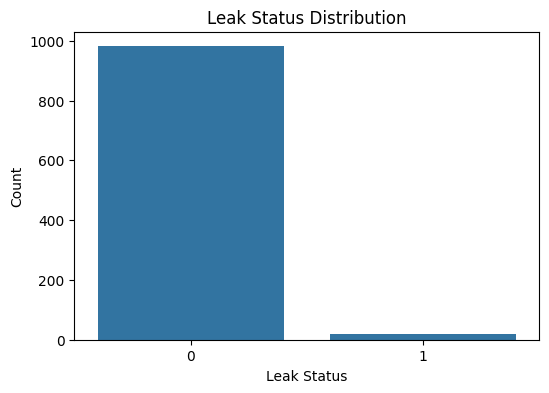

In [2]:
# Summary of the data
print("Dataframe summary:")
print(df.describe())

# Distribution of the Leak Status
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Leak Status')
plt.title("Leak Status Distribution")
plt.xlabel("Leak Status")
plt.ylabel("Count")
plt.show()


In [3]:

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
display(df.describe())


Dataset Shape: (1000, 7)

First few rows:


,Timestamp,Sensor_ID,Pressure (bar),Flow Rate (L/s),Temperature (Â°C),Leak Status,Burst Status
0,2024-01-01 00:00:00,S007,3.694814,77.515218,21.695365,0,0
1,2024-01-01 00:05:00,S007,2.587125,179.926422,19.016725,0,0
2,2024-01-01 00:10:00,S002,2.448965,210.130823,10.011681,1,0
3,2024-01-01 00:15:00,S009,2.936844,141.777934,12.092408,0,0
4,2024-01-01 00:20:00,S003,3.073693,197.484633,17.001443,0,0



Missing values:
Timestamp            0
Sensor_ID            0
Pressure (bar)       0
Flow Rate (L/s)      0
Temperature (Â°C)    0
Leak Status          0
Burst Status         0
dtype: int64

Basic statistics:


,Timestamp,Pressure (bar),Flow Rate (L/s),Temperature (Â°C),Leak Status,Burst Status
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-01-02 17:37:30,3.220696,125.038082,17.434794,0.019000,0.010000
min,2024-01-01 00:00:00,0.910977,50.654490,10.002020,0.000000,0.000000
25%,2024-01-01 20:48:45,2.859332,87.946866,13.715323,0.000000,0.000000
50%,2024-01-02 17:37:30,3.265711,124.106896,17.330067,0.000000,0.000000
75%,2024-01-03 14:26:15,3.607196,162.086708,20.922839,0.000000,0.000000
max,2024-01-04 11:15:00,3.995364,331.754081,24.966107,1.000000,1.000000
std,NaN,0.488997,44.121419,4.288908,0.136593,0.099549


In [4]:
 # Feature engineering: Set the index as Timestamp for timeseries operations
df = df.sort_values('Timestamp')
df = df.set_index('Timestamp')  

# Extract time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

X = df.drop(['Leak Status', 'Burst Status', 'Sensor_ID'], axis=1)
y = df['Leak Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as XGBoost

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return model, y_prob


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       196
           1       0.00      0.00      0.00         4

    accuracy                           0.98       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.96      0.98      0.97       200



/Users/anirudhgoyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anirudhgoyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anirudhgoyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

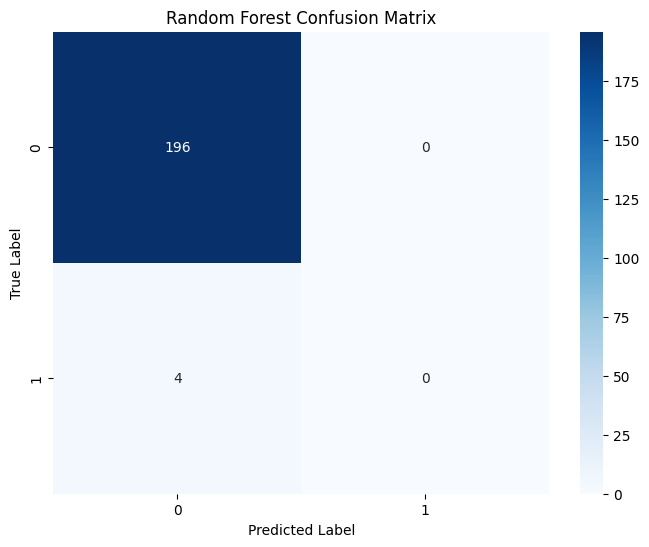

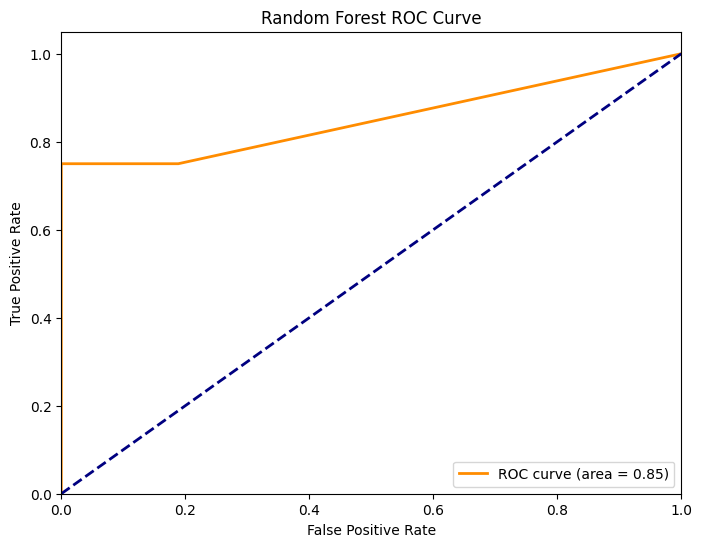


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       196
           1       1.00      0.25      0.40         4

    accuracy                           0.98       200
   macro avg       0.99      0.62      0.70       200
weighted avg       0.99      0.98      0.98       200



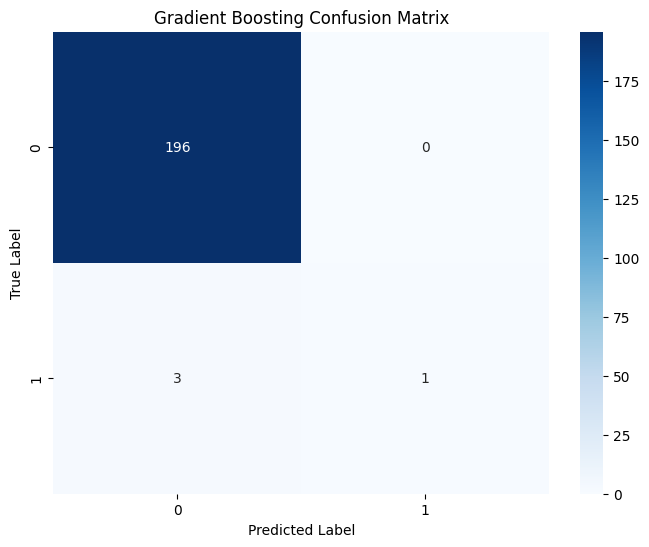

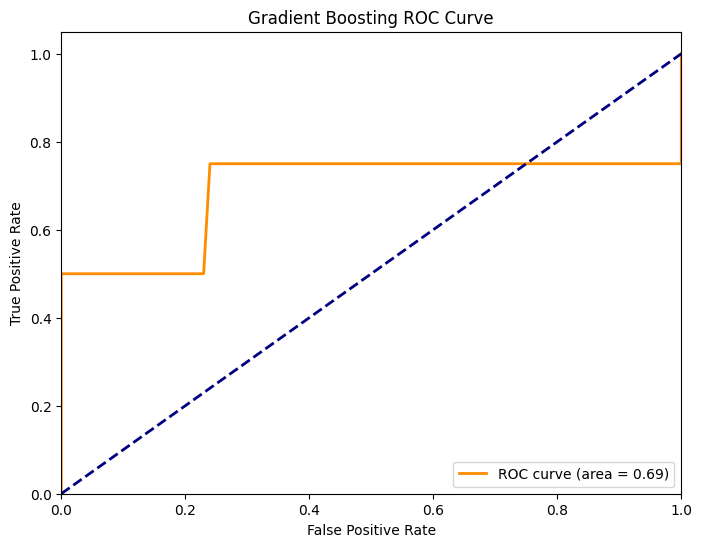

/Users/anirudhgoyal/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       196
           1       1.00      0.25      0.40         4

    accuracy                           0.98       200
   macro avg       0.99      0.62      0.70       200
weighted avg       0.99      0.98      0.98       200



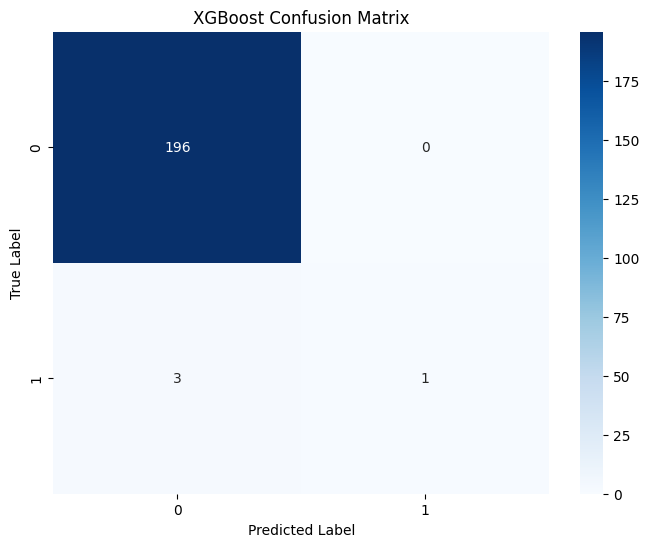

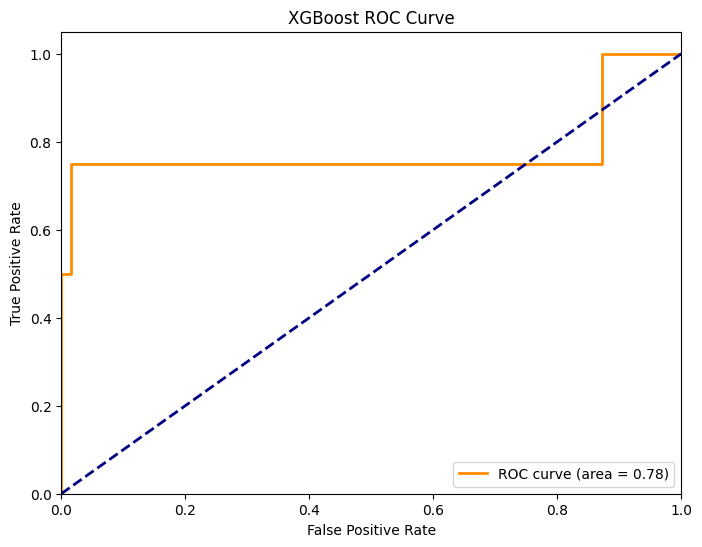

In [9]:
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model, rf_probs = evaluate_model(rf_model, X_train_scaled, y_train,
                                   X_test_scaled, y_test, "Random Forest")

# Train and evaluate Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model, gb_probs = evaluate_model(gb_model, X_train_scaled, y_train,
                                   X_test_scaled, y_test, "Gradient Boosting")

# Train and evaluate XGBoost model
xgb_model = XGBoost.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model, xgb_probs = evaluate_model(xgb_model, X_train_scaled, y_train,
                                     X_test_scaled, y_test, "XGBoost")


In [10]:
def predict_leak_probability(model, new_data, scaler):
    # Preprocess the new data
    new_data_scaled = scaler.transform(new_data)

    # Predict probability
    leak_probs = model.predict_proba(new_data_scaled)[:, 1]

    return leak_probs


In [11]:
test_leak_probs = predict_leak_probability(rf_model, X_test, scaler)

test_df = X_test.copy()
test_df['Actual_Leak'] = y_test
test_df['Leak_Probability'] = test_leak_probs

test_df = test_df.sort_values('Timestamp')
print(test_df.head())


                     Pressure (bar)  Flow Rate (L/s)  Temperature (Â°C)  hour  \
Timestamp                                                                       
2024-01-01 00:05:00        2.587125       179.926422          19.016725     0   
2024-01-01 00:10:00        2.448965       210.130823          10.011681     0   
2024-01-01 00:25:00        2.597577       192.332831          24.484480     0   
2024-01-01 01:10:00        2.595338        96.647348          14.877750     1   
2024-01-01 01:15:00        3.208322        67.939137          20.698672     1   

                     day  month  weekday  Actual_Leak  Leak_Probability  
Timestamp                                                                
2024-01-01 00:05:00    1      1        0            0              0.01  
2024-01-01 00:10:00    1      1        0            1              0.39  
2024-01-01 00:25:00    1      1        0            0              0.00  
2024-01-01 01:10:00    1      1        0            0         

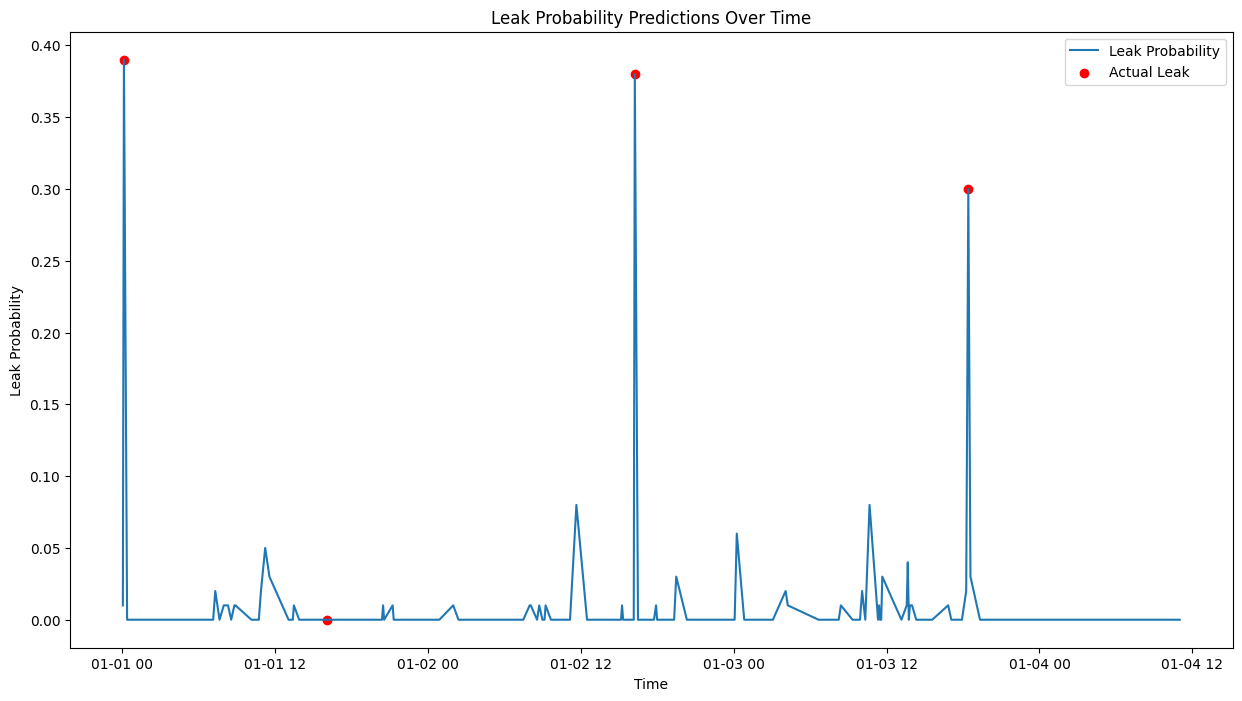

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(test_df.index, test_df['Leak_Probability'], label='Leak Probability')
plt.scatter(test_df[test_df['Actual_Leak'] == 1].index,
           test_df[test_df['Actual_Leak'] == 1]['Leak_Probability'],
           color='red', label='Actual Leak')
plt.title('Leak Probability Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Leak Probability')
plt.legend()
plt.show()
